<a href="https://colab.research.google.com/github/LucasFurlan12/Trabalho-LEA---Lucas-Ferraz-Furlan/blob/main/Ol%C3%A1%2C_este_%C3%A9_o_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import os
import time
import random

def coletar_dados(base_url, paginas):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    todos_dados = []
    incremento = 0  # Começa da página 1 (b_start:int=0)

    for pagina in range(1, paginas + 1):
        url = f"{base_url}?b_start:int={incremento}"
        print(f"\nColetando dados da página {pagina}: {url}")

        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, "html.parser")

            # Encontrar links notícias (classe 'summary url')
            links_noticias = [
                a["href"] for a in soup.find_all("a", class_="summary url")
            ]

            for full_url in links_noticias:
                print(f"Acessando notícia: {full_url}")

                noticia_response = requests.get(full_url, headers=headers, timeout=10)
                noticia_response.raise_for_status()
                noticia_soup = BeautifulSoup(noticia_response.text, "html.parser")

                titulo = noticia_soup.find("meta", property="og:title")
                descricao = noticia_soup.find("meta", attrs={"name": "description"})
                data = noticia_soup.find("meta", property="article:modified_time")
                texto_bloco = noticia_soup.find("div", id="parent-fieldname-text")

                dados = {
                    "titulo": titulo["content"] if titulo else "N/A",
                    "descricao": descricao["content"] if descricao else "N/A",
                    "data": data["content"] if data else "N/A",
                    "texto": texto_bloco.get_text(separator="\n").strip() if texto_bloco else "N/A",
                    "url": full_url
                }

                todos_dados.append(dados)
                time.sleep(random.uniform(2, 4))  # Tempo aleatório para evitar ban

        except requests.exceptions.RequestException as e:
            print(f"Erro ao acessar {url}: {e}")

        incremento += 45  # Incrementa para próxima página, que é o mesmo link mas no final o incremento aumenta 45 unidades a cada pagina a mais

    return todos_dados

# Salvando e Json
def salvar_json(dados, pasta, nome_arquivo):
    if not os.path.exists(pasta):
        os.makedirs(pasta)
    caminho = os.path.join(pasta, nome_arquivo)
    with open(caminho, "w", encoding="utf-8") as f:
        json.dump(dados, f, ensure_ascii=False, indent=4)
    print(f"\nDados salvos em: {caminho}")

url_base = "https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/ultimas-noticias"

dados_coletados = coletar_dados(url_base, 5)

salvar_json(dados_coletados, pasta="data", nome_arquivo="noticias_planalto.json")



Coletando dados da página 1: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/ultimas-noticias?b_start:int=0
Acessando notícia: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/noticias/2024/12/lula-sobre-reforma-tributaria-201csistema-mais-simples-eficiente-justo-e-transparente201d
Acessando notícia: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/noticias/2024/12/presidente-sanciona-lei-que-autoriza-criacao-do-cadastro-nacional-de-animais-de-estimacao
Acessando notícia: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/noticias/2024/12/decreto-promulga-protocolo-sobre-direitos-da-crianca-que-delimita-canais-para-denuncia-de-violacoes
Acessando notícia: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/noticias/2024/12/presidente-regulamenta-pensao-para-vitimas-da-hanseniase-e-filhos-separados-devido-a-internacao-compulsoria
Acessando notícia: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/noticias/2024/12/presidente-lula-encaminha-ao-senado-a-ind

In [3]:
import os
print(os.listdir("data"))


['noticias_planalto.json']


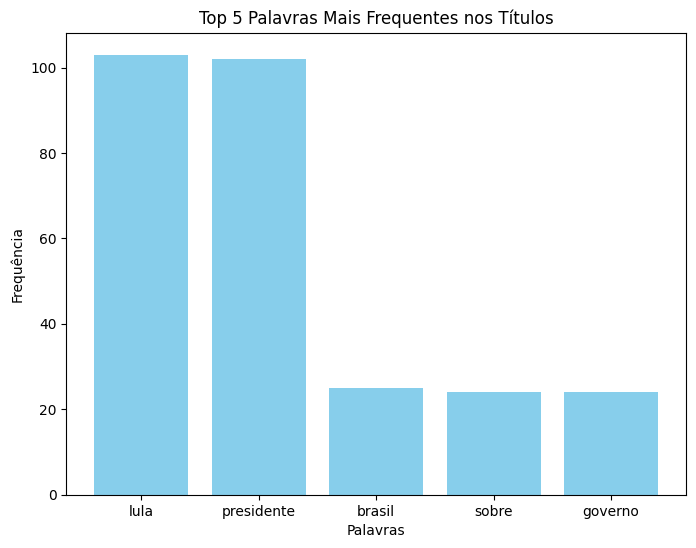

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re

df = pd.read_json("data/noticias_planalto.json")

todos_os_textos = " ".join(df["titulo"].dropna()).lower()

# Remover pontuação e números
todos_os_textos_limpo = re.sub(r"[^a-zA-Zà-úÀ-ÚçÇ\s]", "", todos_os_textos)
palavras = todos_os_textos_limpo.split()

# Contar palavras mais frequentes (ignorando stopwords simples)
stopwords = {"de", "a", "e", "o", "do", "da", "em", "que", "um", "para", "no", "na", "é", "os", "dos", "com"}
palavras_filtradas = [palavra for palavra in palavras if palavra not in stopwords]

# Contagem das palavras
contador_palavras = Counter(palavras_filtradas)

# Obter as 5 palavras mais frequentes
top5_palavras = contador_palavras.most_common(5)

# Separar palavras e contagens para o gráfico
palavras, contagens = zip(*top5_palavras)

# Gerar gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(palavras, contagens, color="skyblue")
plt.title("Top 5 Palavras Mais Frequentes nos Títulos")
plt.xlabel("Palavras")
plt.ylabel("Frequência")
plt.show()


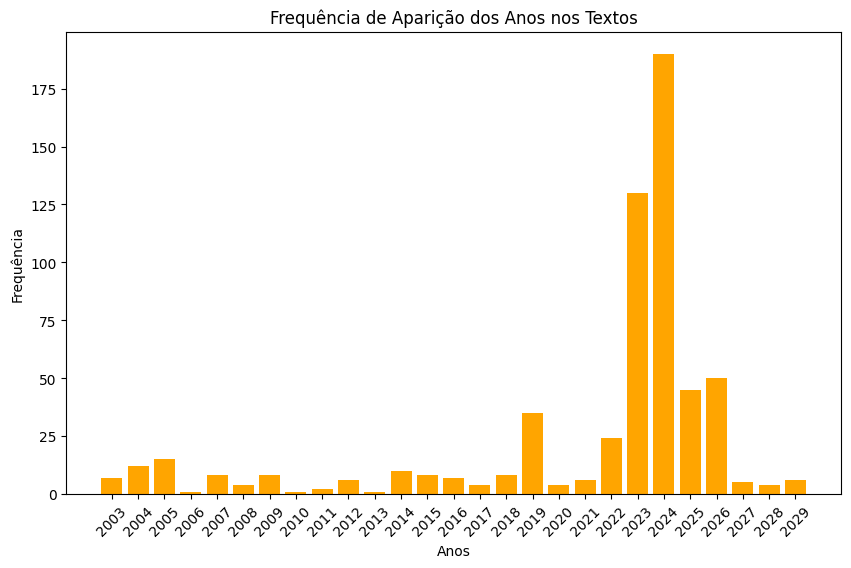

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

df = pd.read_json("data/noticias_planalto.json")
todos_os_textos = " ".join(df["texto"].dropna())

# Encontrar todos os anos no texto (2000 até 2025)
anos_encontrados = re.findall(r"\b(20[0-2][0-9]|2025)\b", todos_os_textos)

# Contar a frequência dos anos
contador_anos = Counter(anos_encontrados)

# Ordenar os anos para o gráfico
anos_ordenados = sorted(contador_anos.items())
anos, frequencias = zip(*anos_ordenados)

# Gerar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(anos, frequencias, color="orange")
plt.title("Frequência de Aparição dos Anos nos Textos")
plt.xlabel("Anos")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.show()


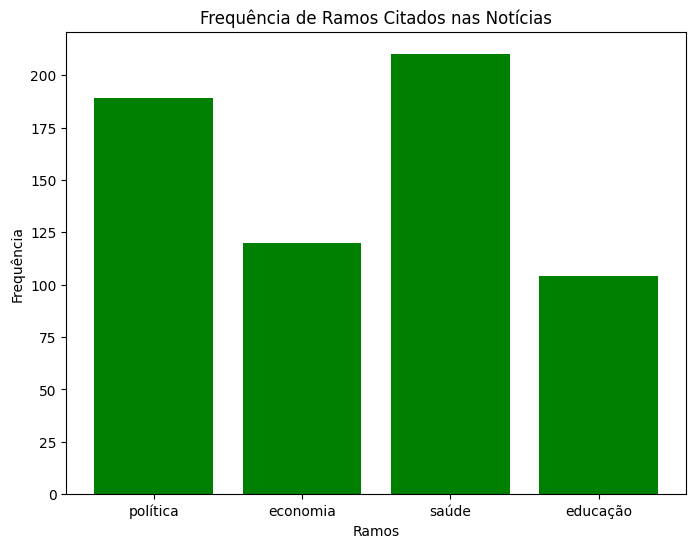

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json("data/noticias_planalto.json")
todos_os_textos = " ".join(df["texto"].dropna()).lower()

# Termos a serem pesquisados
ramos = ["política", "economia", "saúde", "educação"]

# Contar a frequência de cada ramo
frequencias = {ramo: todos_os_textos.count(ramo) for ramo in ramos}

# Separar dados para o gráfico
ramos_labels = list(frequencias.keys())
frequencias_valores = list(frequencias.values())

# Gerar o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(ramos_labels, frequencias_valores, color="green")
plt.title("Frequência de Ramos Citados nas Notícias")
plt.xlabel("Ramos")
plt.ylabel("Frequência")
plt.show()


Tamanho médio dos textos:
Com 'presidente': 4125.60 caracteres
Sem 'presidente': 3544.33 caracteres


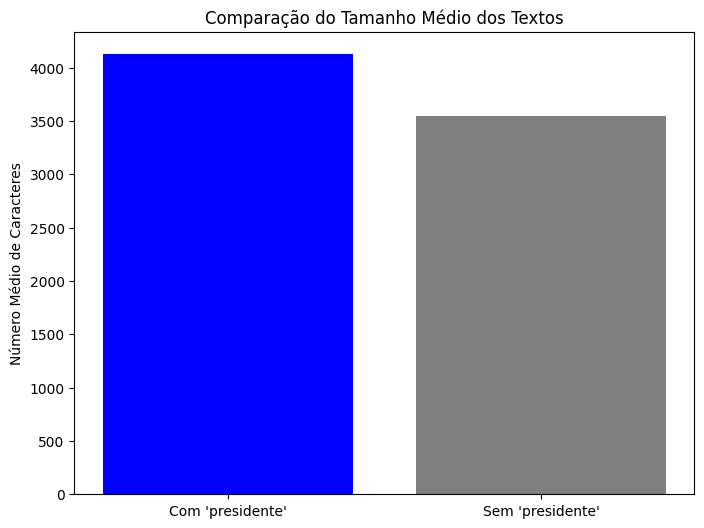

In [7]:
import pandas as pd

df = pd.read_json("data/noticias_planalto.json")
df = df.dropna(subset=["texto"])  # Remove entradas sem texto

# Criar duas categorias: textos com 'presidente' e sem 'presidente'
df["tem_presidente"] = df["texto"].str.contains(r"\bpresidente\b", case=False, na=False)

# Calcular o tamanho dos textos
df["tamanho_texto"] = df["texto"].apply(len)

# Calcular médias para os dois grupos
media_com_presidente = df[df["tem_presidente"]]["tamanho_texto"].mean()
media_sem_presidente = df[~df["tem_presidente"]]["tamanho_texto"].mean()

# Exibir os resultados
print("Tamanho médio dos textos:")
print(f"Com 'presidente': {media_com_presidente:.2f} caracteres")
print(f"Sem 'presidente': {media_sem_presidente:.2f} caracteres")

# Gráfico comparativo
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(["Com 'presidente'", "Sem 'presidente'"], [media_com_presidente, media_sem_presidente], color=["blue", "gray"])
plt.title("Comparação do Tamanho Médio dos Textos")
plt.ylabel("Número Médio de Caracteres")
plt.show()
